dead time effect = 0.9503605102606767


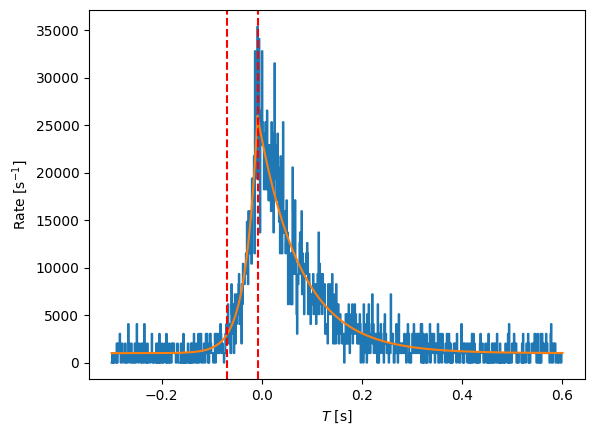

In [1]:
import matplotlib.pyplot as plt
import numba as nb
import numpy as np

from chronpy.data import LightCurve
from chronpy.modwt.wavelet import MODWTVariance
from chronpy.psd import Fit, Periodogram
from chronpy.psd.models import PL, BentPL, BrokenPL, Const


@nb.njit('float64[:](float64[::1], float64)')
def apply_non_extending_dead_time(t, dt):
    evts = np.empty_like(t)
    n = 0
    alive_time = t[0]
    for i in range(t.size):
        if t[i] >= alive_time:
            evts[n] = t[i]
            alive_time = t[i] + dt
            n += 1
    return evts[:n]


@nb.njit(nb.float64[:](nb.float64[:], nb.float64[:]))
def fred_vec(t, args):
    A, t_max, sigma_r, sigma_d, v, b = args
    sigma = np.where(t <= t_max, sigma_r, sigma_d)
    signal = A * np.exp(-(((np.abs(t - t_max)) / sigma) ** v)) + b
    return signal


@nb.njit(nb.float64(nb.float64, nb.float64[:]))
def fred(t, args):
    A, t_max, sigma_r, sigma_d, v, b = args
    sigma = sigma_r if t <= t_max else sigma_d
    signal = A * np.exp(-(((np.abs(t - t_max)) / sigma) ** v)) + b
    return signal


@nb.njit(
    nb.float64[:](
        nb.types.FunctionType(nb.float64(nb.float64, nb.float64[:])),
        nb.float64[:],
        nb.float64,
        nb.float64,
        nb.float64,
        nb.int64,
    )
)
def simulate_events(ft, args, ftmax, t0, t1, seed):
    """Algorithm 6"""
    np.random.seed(seed)
    t = t0
    events = []
    # i = 0
    while t <= t1:
        t = t - np.log(np.random.rand()) / ftmax
        if np.random.rand() <= ft(t, args) / ftmax:
            events.append(t)
    #    i += 1
    # events.append(i)
    return np.array(events)


t = np.arange(-0.3, 0.6, 0.00001)
pars = np.array([25000, -8.7e-3, 24.0e-3, 84.0e-3, 1.0, 1000])
# plt.plot(t, fred_vec(t, pars))
# plt.xlabel('$T$ [s]')
# plt.ylabel('Rate [s$^{-1}$]')
evts0 = simulate_events(fred, pars, 100000.0, -0.3, 0.6, seed=42)
evts = apply_non_extending_dead_time(evts0, 4e-6)
print('dead time effect =', len(evts) / len(evts0))
bins = np.arange(-0.3, 0.6, 1e-3)
lc = np.histogram(evts, bins)[0]
expo = (
    np.diff(bins)
    - np.histogram(evts, bins, weights=np.ones_like(evts) * 4e-6)[0]
)
rate = lc / expo
plt.figure()
plt.step(bins, np.append(rate, rate[-1]), where='post')
plt.plot(t, fred_vec(t, pars))
plt.xlabel('$T$ [s]')
plt.ylabel('Rate [s$^{-1}$]')
plt.axvline(-8.7 / 1000, color='r', ls='--')
plt.axvline(-8.7 / 1000 - 60 / 1000, color='r', ls='--')

{'BentPL.alpha': Array(2.68962897, dtype=float64), 'BentPL.fb': Array(3.54227793, dtype=float64), 'BentPL.A': Array(835.7112155, dtype=float64), 'Const.C': Array(1.9390514, dtype=float64)}
2.12461565466901
1.2071909775517448e-10


Text(0.5, 0, 'Frequency [Hz]')

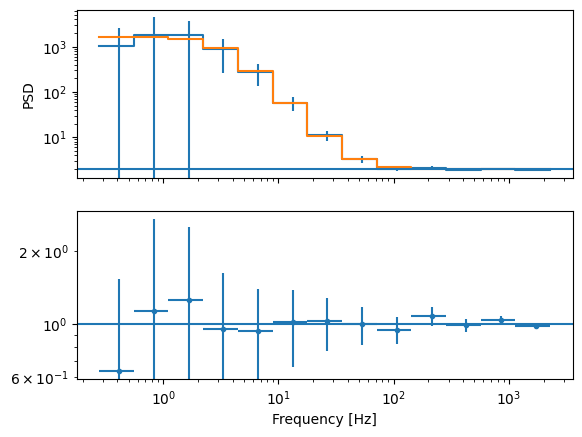

In [2]:
bins = np.linspace(-0.3, 0.6, 2**12 + 1)
counts = np.histogram(evts, bins)[0]
expo = (
    np.diff(bins)
    - np.histogram(evts, bins, weights=np.ones_like(evts) * 4e-6)[0]
)
lc = LightCurve(0.5 * (bins[:-1] + bins[1:]), counts, bins, expo)
wavelet_ps = MODWTVariance.from_lc(lc)

fit = Fit(wavelet_ps, BentPL(nsub=100) + Const())
constr_params, deviance, g = fit.mle_lm()
# # constr_params, deviance, g = fit.mle_lm(constr_params|{'Constant.C':2.0})
print(constr_params, deviance, g, sep='\n')
freq = wavelet_ps.freq
fbins = wavelet_ps.freq_bins
d = wavelet_ps.density
derr = wavelet_ps.derr
m = fit.model.power(constr_params, fit.psd.freq_bins) / wavelet_ps.bins_width
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].step(fbins, np.append(d, d[-1]), where='post')
axs[0].errorbar(freq, d, derr, fmt=' ', c='C0')
axs[0].step(fit.psd.freq_bins, np.append(m, m[-1]), where='post')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel('PSD')
axs[0].axhline(2)
axs[1].errorbar(
    fit.psd.freq, d / m, derr / m, fit.psd.bins_width * 0.5, fmt='. '
)
axs[1].axhline(1)
axs[1].set_yscale('log')
axs[1].set_xlabel('Frequency [Hz]')

[]

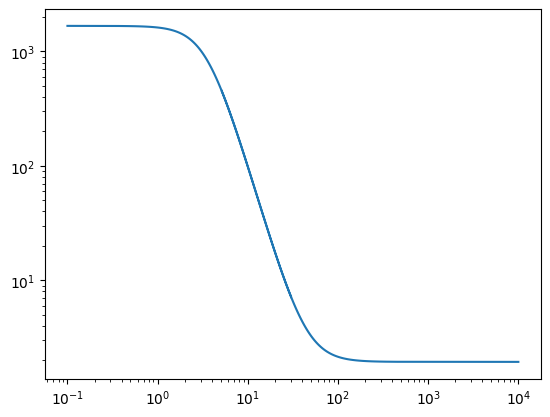

In [3]:
freq_bins = np.geomspace(0.1, 1e4, 10000)
mp = fit.model.power(constr_params, freq_bins) / np.diff(freq_bins)
plt.step(freq_bins, np.append(mp, mp[-1]), where='post')
plt.loglog()

In [4]:
res = fit.run_nuts()
res.log_likelihood['total'] = res.log_likelihood['I_obs'].sum('I_obs_dim_0')

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

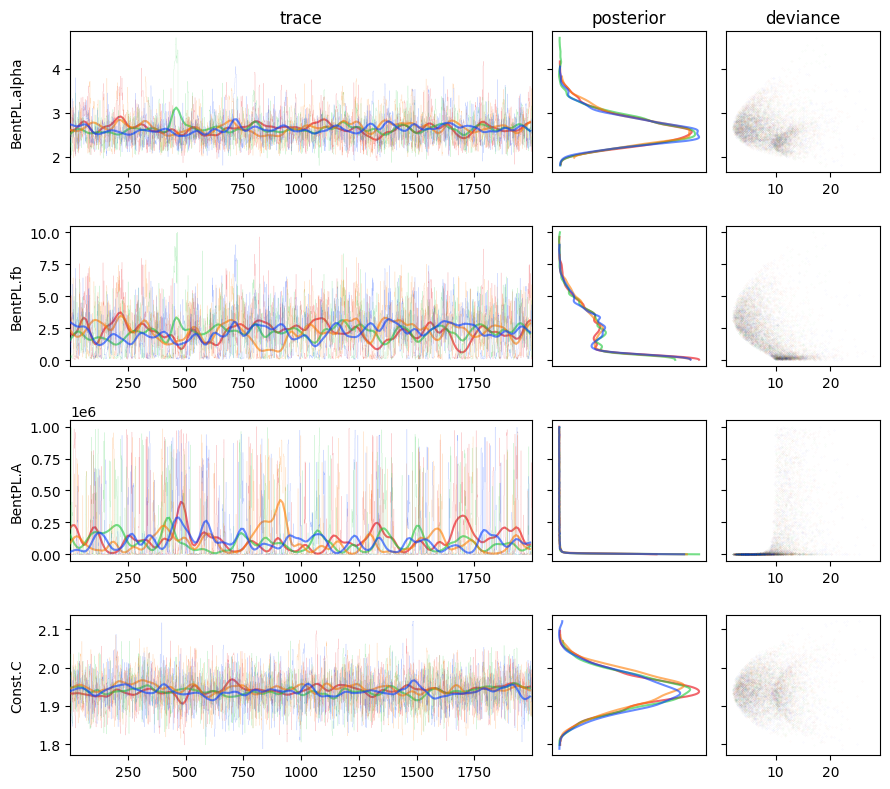

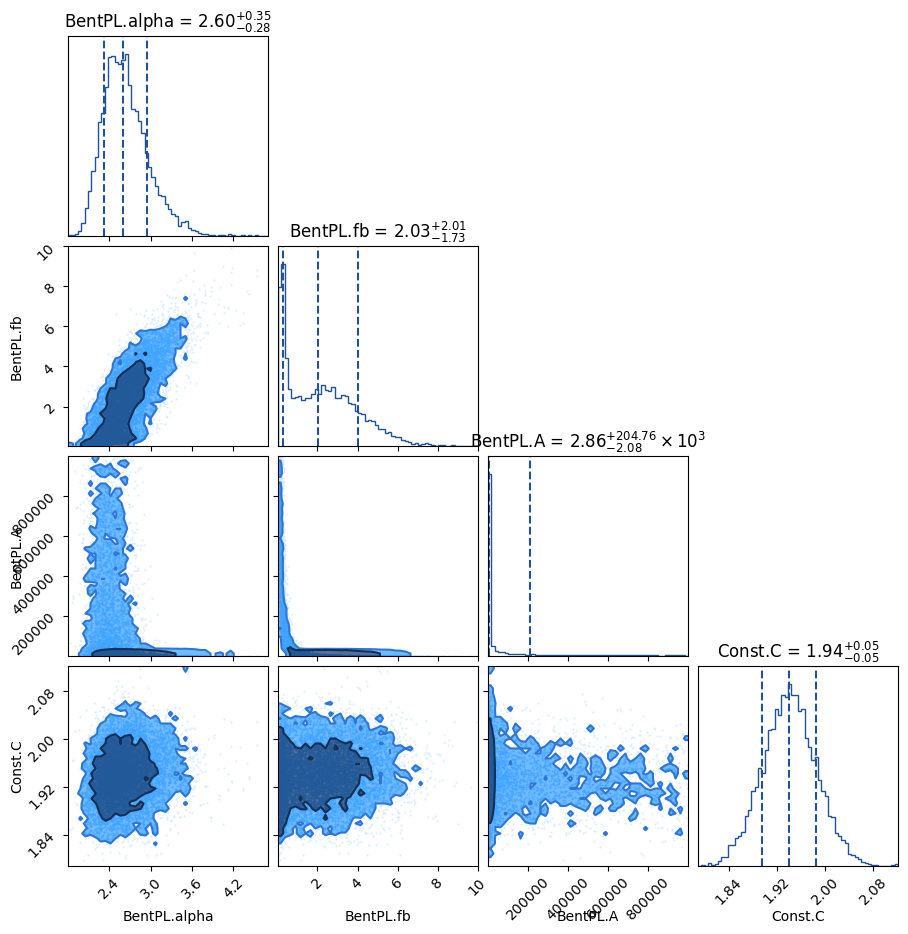

In [5]:
from elisa.plot.misc import plot_corner, plot_trace

res.log_likelihood['total'] = res.log_likelihood['I_obs'].sum('I_obs_dim_0')
_ = plot_trace(res, params=fit.params_names)
_ = plot_corner(res, params=fit.params_names)

Fitting: 100%|██████████| 10000/10000 [00:07<00:00, 1410.81it/s]


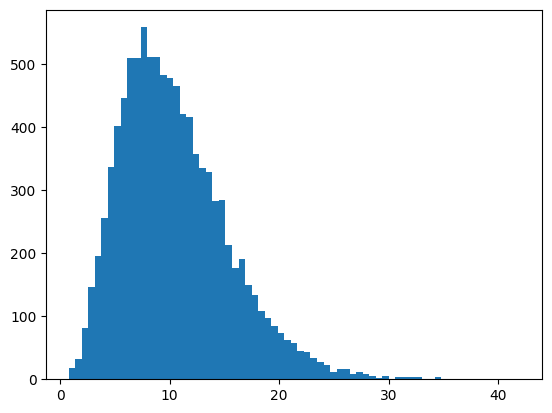

In [6]:
samples = fit.simulate(constr_params, 10000)
boot = fit.batch_fit(samples, constr_params)
_ = plt.hist(boot['deviance']['total'], 'auto')

{'PL.alpha': Array(2.27338401, dtype=float64), 'PL.A': Array(13056.32934279, dtype=float64), 'Const.C': Array(1.92888907, dtype=float64)}
9.811374635369063
5.491829280420282e-09


Text(0.5, 0, 'Frequency [Hz]')

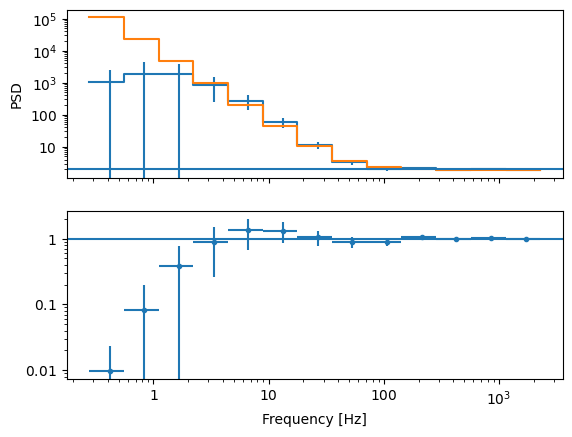

In [7]:
fit = Fit(wavelet_ps, PL() + Const())
constr_params, deviance, g = fit.mle_lm()
# # constr_params, deviance, g = fit.mle_lm(constr_params|{'Constant.C':2.0})
print(constr_params, deviance, g, sep='\n')
freq = wavelet_ps.freq
fbins = wavelet_ps.freq_bins
d = wavelet_ps.density
derr = wavelet_ps.derr
m = fit.model.power(constr_params, fit.psd.freq_bins) / wavelet_ps.bins_width
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].step(fbins, np.append(d, d[-1]), where='post')
axs[0].errorbar(freq, d, derr, fmt=' ', c='C0')
axs[0].step(fit.psd.freq_bins, np.append(m, m[-1]), where='post')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel('PSD')
axs[0].axhline(2)
axs[1].errorbar(
    fit.psd.freq, d / m, derr / m, fit.psd.bins_width * 0.5, fmt='. '
)
axs[1].axhline(1)
axs[1].set_yscale('log')
axs[1].set_xlabel('Frequency [Hz]')

In [8]:
bins = np.arange(-0.3, 0.6, 0.002)
counts = np.histogram(evts, bins)[0]
expo = (
    np.diff(bins)
    - np.histogram(evts, bins, weights=np.ones_like(evts) * 4e-6)[0]
)
lc = LightCurve(0.5 * (bins[:-1] + bins[1:]), counts, bins, expo)
pxx = Periodogram.from_lc(lc, norm='leahy')
pxx_rebin = pxx.rebin_log(f=0.05)
ps_rebin3 = pxx.rebin_significance(3)
model = BrokenPL() + Const()
init = {
    'BrokenPL.A': 2247.7777351327663,
    'BrokenPL.alpha1': 1.167462226243316,
    'BrokenPL.alpha2': 3.4717653037403657,
    'BrokenPL.fb': 4.559816895259903,
    'Const.C': 1.7087944083648663,
}
fit = Fit(pxx_rebin, model)
# idata = fit.run_nuts(1000, 2000, init=init)

{'BentPL.alpha': Array(3.4319501, dtype=float64), 'BentPL.fb': Array(2.86671868, dtype=float64), 'BentPL.A': Array(1314.0647753, dtype=float64), 'Const.C': Array(1.90747922, dtype=float64)}
232.28484496766538
224
9.967786268264804e-07


Array(1., dtype=float64)

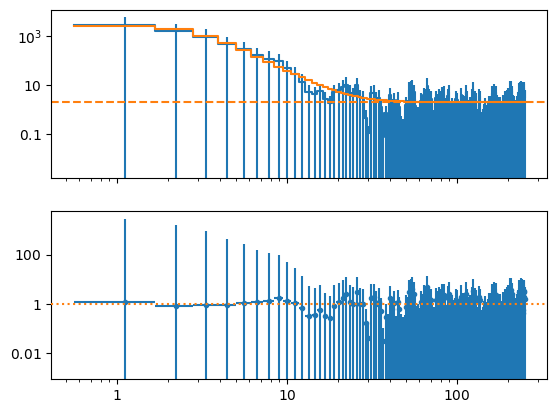

In [9]:
fit = Fit(pxx, BentPL(nsub=10) + Const())
constr_params, deviance, g = fit.mle()
print(constr_params, deviance, fit.psd.power.size, g, sep='\n')
# constr_params, deviance, g = fit.mle_lm(init)
# print(constr_params, deviance, g, sep='\n')
freq = fit.psd.freq
freq_bins = fit.psd.freq_bins
d = fit.psd.density
derr = fit.psd.derr
m = fit.model.power(constr_params, fit.psd.freq_bins) / fit.psd.bins_width
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].step(freq_bins, np.append(d, d[-1]), where='post')
axs[0].errorbar(freq, d, derr, fmt=' ', c='C0')
axs[0].step(freq_bins, np.append(m, m[-1]), where='post')
axs[0].axhline(constr_params['Const.C'], color='C1', ls='--')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].errorbar(freq, d / m, derr, fit.psd.bins_width * 0.5, fmt='. ')
axs[1].axhline(1, color='C1', ls=':', zorder=10)
axs[1].set_yscale('log')
# axs[0].set_xlim(freq_bins[0], freq_bins[-1])
np.mean(d / m)

{'BentPL.alpha': Array(3.4319496, dtype=float64), 'BentPL.fb': Array(2.86671752, dtype=float64), 'BentPL.A': Array(1314.06521203, dtype=float64), 'Const.C': Array(1.90747921, dtype=float64)}
232.28484258200555
224
5.18960640656196e-07


Array(1., dtype=float64)

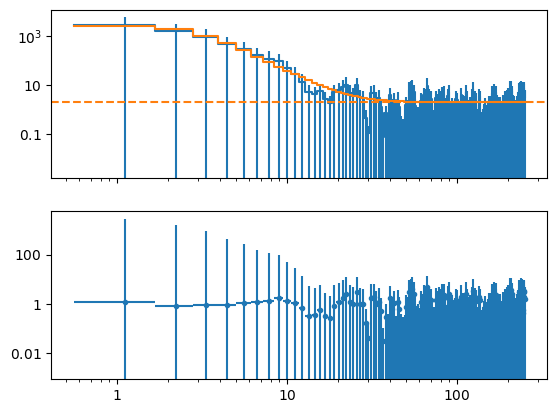

In [10]:
fit = Fit(pxx, BentPL(nsub=6) + Const())
constr_params, deviance, g = fit.mle()
print(constr_params, deviance, fit.psd.power.size, g, sep='\n')
# constr_params, deviance, g = fit.mle_lm(init)
# print(constr_params, deviance, g, sep='\n')
freq = fit.psd.freq
freq_bins = fit.psd.freq_bins
d = fit.psd.density
derr = fit.psd.derr
m = fit.model.power(constr_params, fit.psd.freq_bins) / fit.psd.bins_width
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].step(freq_bins, np.append(d, d[-1]), where='post')
axs[0].errorbar(freq, d, derr, fmt=' ', c='C0')
axs[0].step(freq_bins, np.append(m, m[-1]), where='post')
axs[0].axhline(constr_params['Const.C'], color='C1', ls='--')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].errorbar(freq, d / m, derr, fit.psd.bins_width * 0.5, fmt='. ')
axs[1].set_yscale('log')
np.mean(d / m)

In [16]:
res = fit.run_nuts(init=init)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

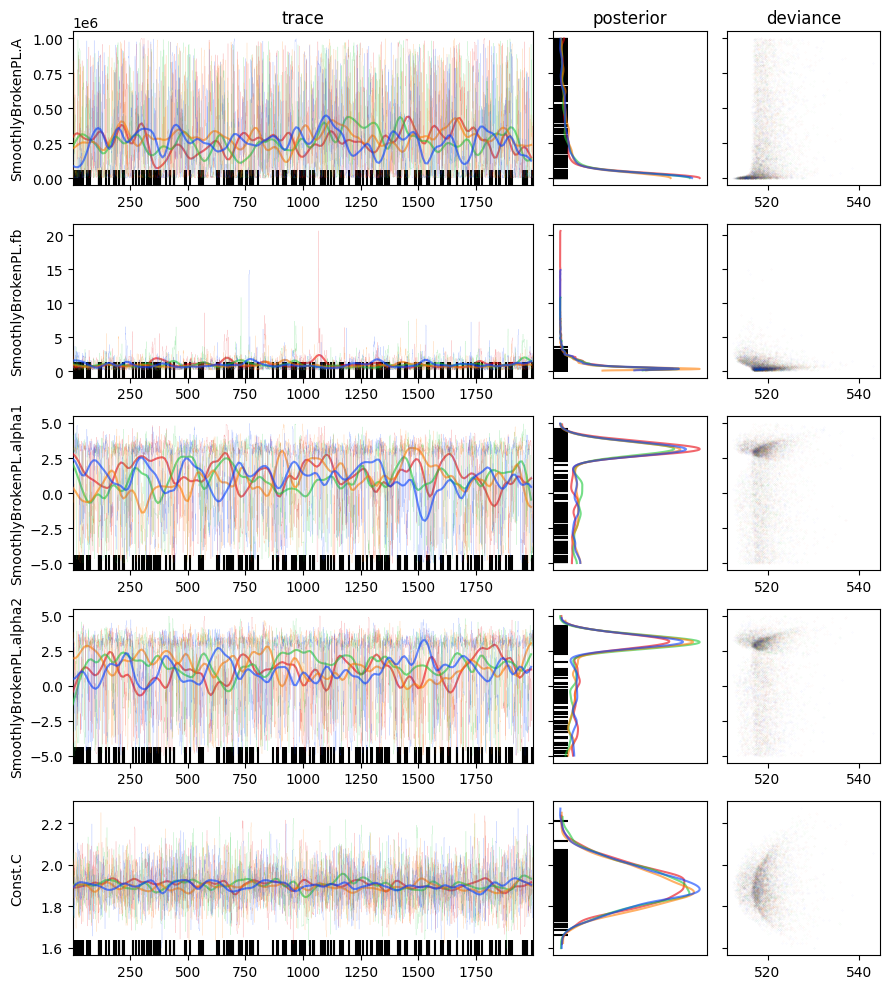

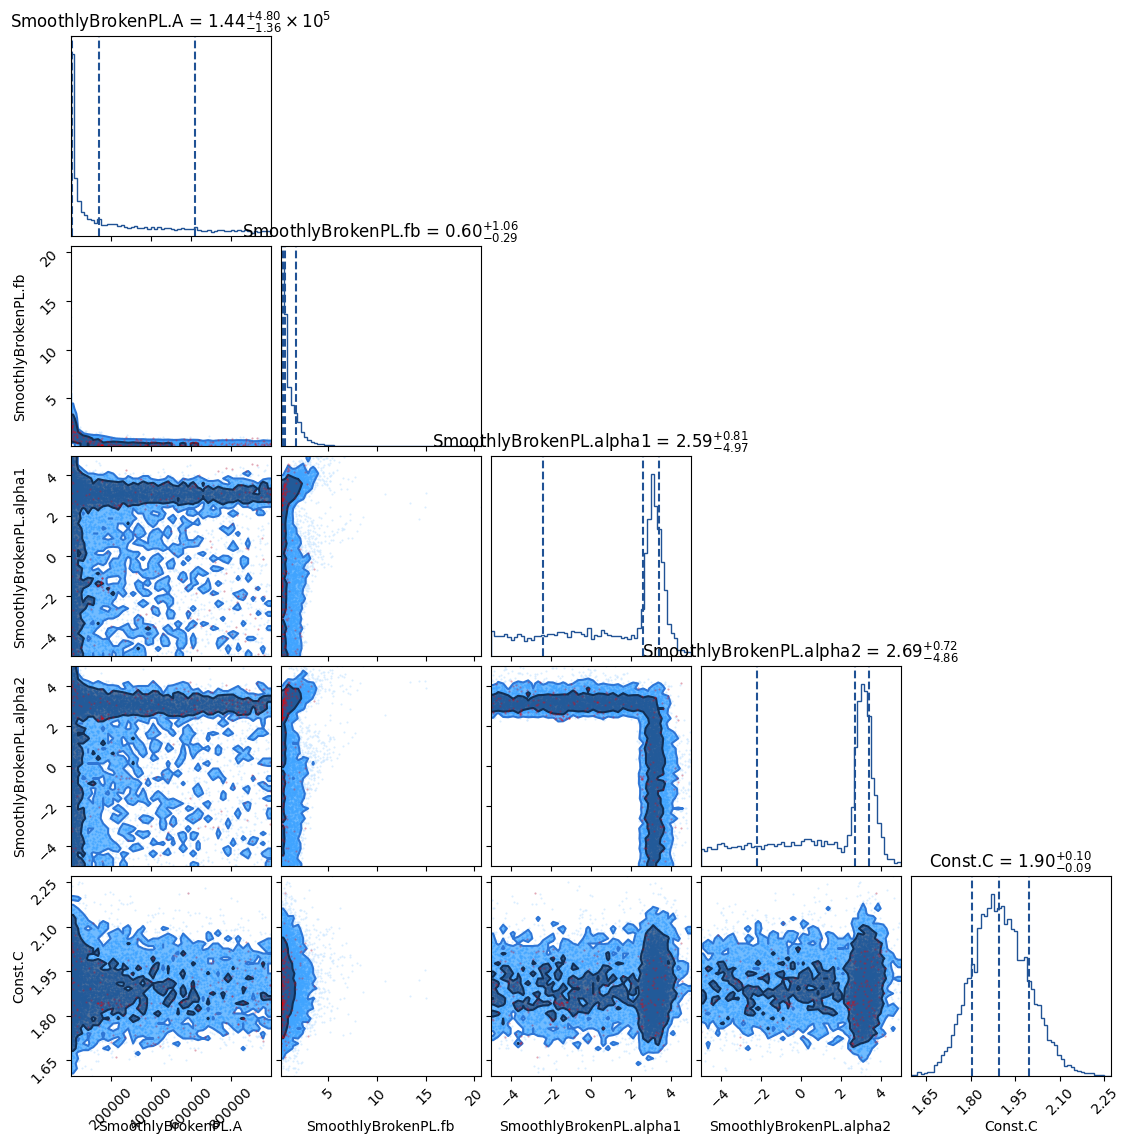

In [17]:
from elisa.plot.misc import plot_corner, plot_trace

res.log_likelihood['total'] = res.log_likelihood['I_obs'].sum('I_obs_dim_0')
plot_trace(res, params=fit.params_names)
_ = plot_corner(res, params=fit.params_names)

In [18]:
(
    deviance,
    (fit.psd.freq.size - 5),
    deviance + 2 * 5,
    deviance + 2 * np.log(pxx.power.size),
)

(Array(512.36299337, dtype=float64),
 444,
 Array(522.36299337, dtype=float64),
 Array(524.57703915, dtype=float64))

{'PL.alpha': Array(2.8805126, dtype=float64), 'PL.A': Array(22988.38732559, dtype=float64), 'Const.C': Array(1.87948167, dtype=float64)}
516.86 / 446
2.8295583201901327e-09


Array(0.899, dtype=float64)

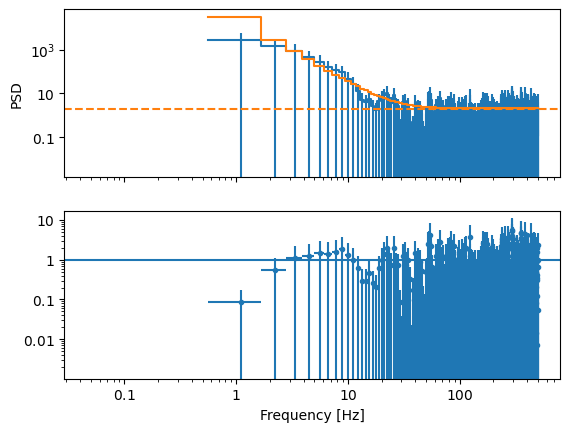

In [19]:
fit_plc = Fit(pxx, PL() + Const())
params, f, g = fit_plc.mle_lm()
print(params, f'{f:.2f} / {fit_plc.ndata - fit_plc.nparam}', g, sep='\n')
freq = fit_plc.psd.freq
fbins = fit_plc.psd.freq_bins
d = fit_plc.psd.density
derr = fit_plc.psd.derr
m = fit_plc.model.power(params, fit_plc.psd.freq_bins)
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].step(fbins, np.append(d, d[-1]), where='post')
axs[0].errorbar(freq, d, derr, fmt=' ', c='C0')
axs[0].step(fbins, np.append(m, m[-1]), where='post')
axs[0].axhline(params['Const.C'], color='C1', ls='--')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel('PSD')
axs[1].errorbar(freq, d / m, derr / m, fit_plc.psd.bins_width * 0.5, fmt='. ')
axs[1].axhline(1)
axs[1].set_yscale('log')
axs[1].set_xlabel('Frequency [Hz]')
np.mean(d / m)

In [20]:
f + 3 * 2, f + 3 * np.log(pxx_rebin.power.size)

(Array(522.86280725, dtype=float64), Array(526.85942078, dtype=float64))

In [ ]:
samples = fit_plc.simulate(params, 10000)
res = fit.batch_fit(samples)

Fitting:  14%|█▍        | 1450/10000 [00:59<04:55, 28.90it/s]

(array([5.74617819e-05, 2.87308910e-05, 5.74617819e-05, 1.43654455e-04,
        1.72385346e-04, 6.03348710e-04, 7.47003165e-04, 1.00558118e-03,
        1.35035188e-03, 2.06862415e-03, 3.18912890e-03, 4.94171325e-03,
        5.34394572e-03, 6.29206512e-03, 7.64241700e-03, 7.95845680e-03,
        9.68231026e-03, 9.30880867e-03, 1.06878914e-02, 9.25134689e-03,
        1.02281972e-02, 1.06016988e-02, 9.02149977e-03, 8.13084214e-03,
        7.29764631e-03, 6.23460334e-03, 4.48201899e-03, 3.73501583e-03,
        3.18912890e-03, 1.83877702e-03, 2.09735504e-03, 1.06304297e-03,
        1.09177386e-03, 6.60810492e-04, 4.30963365e-04, 5.74617819e-04,
        2.58578019e-04, 2.01116237e-04, 2.29847128e-04, 1.72385346e-04,
        2.87308910e-04, 1.14923564e-04, 2.01116237e-04, 2.87308910e-05,
        1.14923564e-04, 2.29847128e-04, 5.74617819e-05, 3.16039801e-04,
        2.87308910e-04, 2.58578019e-04, 2.87308910e-04, 2.29847128e-04,
        2.58578019e-04, 2.87308910e-04, 2.01116237e-04, 2.873089

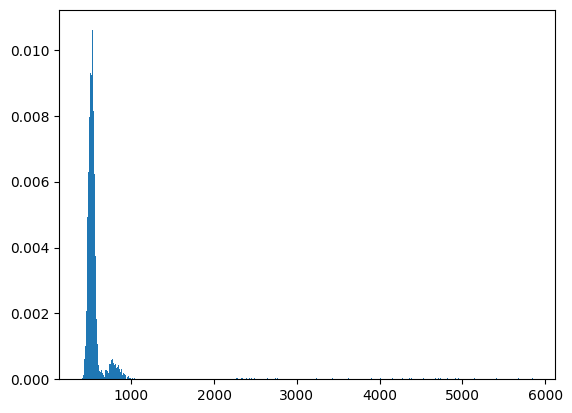

In [8]:
plt.hist(res['deviance']['total'][res['valid']], 'auto', density=True)
# plt.axvline(fit_plc.mle_lm()[1])

In [9]:
res2 = fit_plc.batch_fit(samples, fit_plc.mle_lm()[0])

  0%|          | 0/10000 [00:00<?, ?it/s]

[]

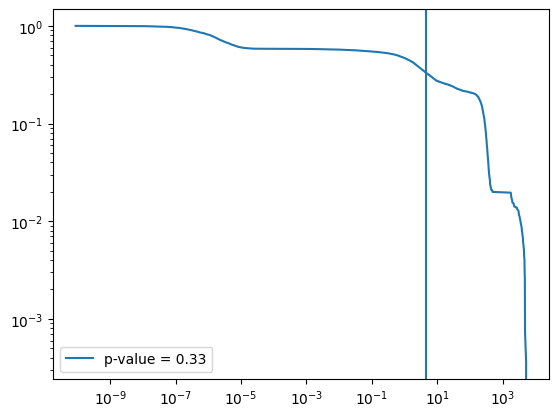

In [10]:
valid = res['valid'] & res2['valid']
valid &= res2['deviance']['total'] < res['deviance']['total']
diff = (res['deviance']['total'] - res2['deviance']['total'])[valid]
plt.plot(np.sort(diff), 1 - np.arange(1, diff.size + 1) / diff.size)
diff_obs = fit_plc.mle_lm()[1] - fit.mle_lm(init)[1]
pvalue = np.sum(diff > diff_obs) / diff.size
plt.axvline(diff_obs, label=f'p-value = {pvalue:.2f}')
plt.legend()
plt.loglog()

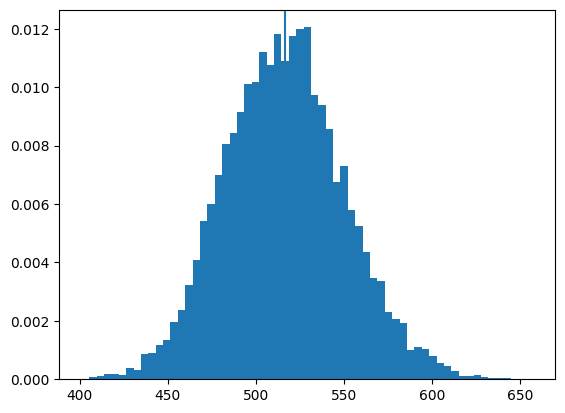

In [11]:
plt.hist(res2['deviance']['total'][res2['valid']], 'auto', density=True)
plt.axvline(fit_plc.mle_lm()[1])

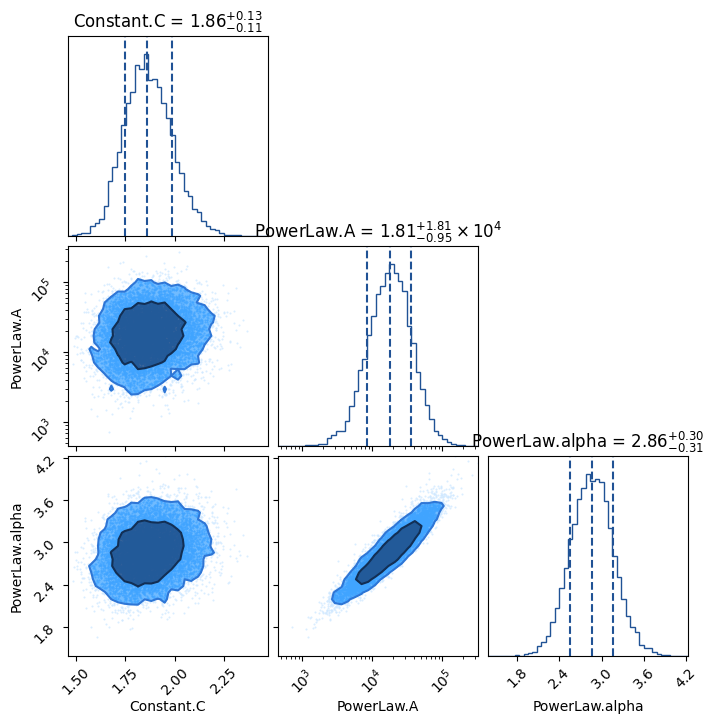

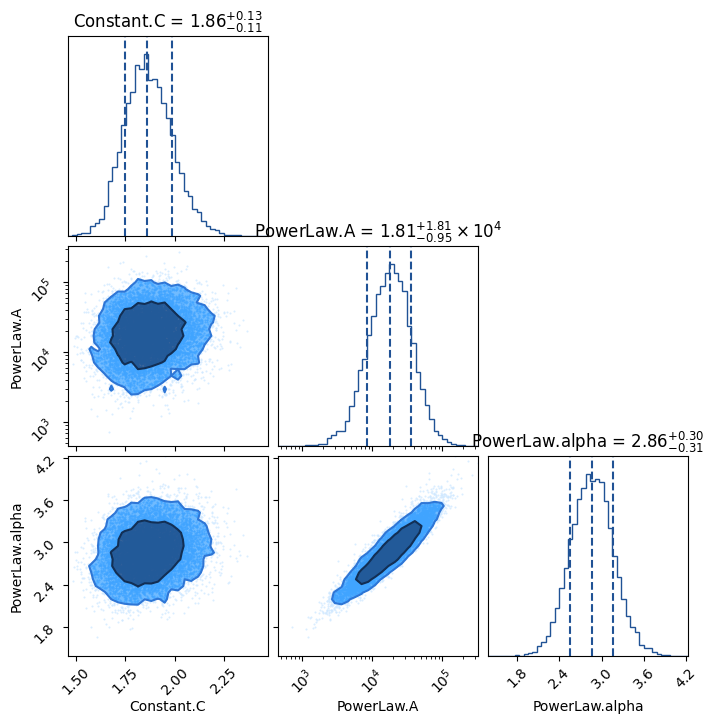

In [18]:
import arviz as az
from elisa.plot.misc import plot_corner

plot_corner(
    az.from_dict(res2['params']),
    bins=30,
    axes_scale=['linear', 'log', 'linear'],
)

In [7]:
idata = az.from_dict(res2['params'])
lower, mid, upper = (
    idata.posterior['S']
    .quantile(q=[0.5 - 0.683 / 2, 0.5, 0.5 + 0.683 / 2], dim=['chain', 'draw'])
    .values
)
plt.figure()
plt.step(
    pxx_rebin.freq_bins,
    np.append(pxx_rebin.power, pxx_rebin.power[-1]),
    where='post',
)
plt.errorbar(pxx_rebin.freq, pxx_rebin.power, pxx_rebin.error, fmt=' ', c='C0')
plt.step(pxx_rebin.freq_bins, np.append(mid, mid[-1]), where='post')
plt.fill_between(
    pxx_rebin.freq_bins,
    np.append(lower, lower[-1]),
    np.append(upper, upper[-1]),
    alpha=0.5,
    step='post',
)
plt.loglog()

NameError: name 'idata' is not defined

 Solar Abundance Vector set to angr:  Anders E. & Grevesse N. Geochimica et Cosmochimica Acta 53, 197 (1989)
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996


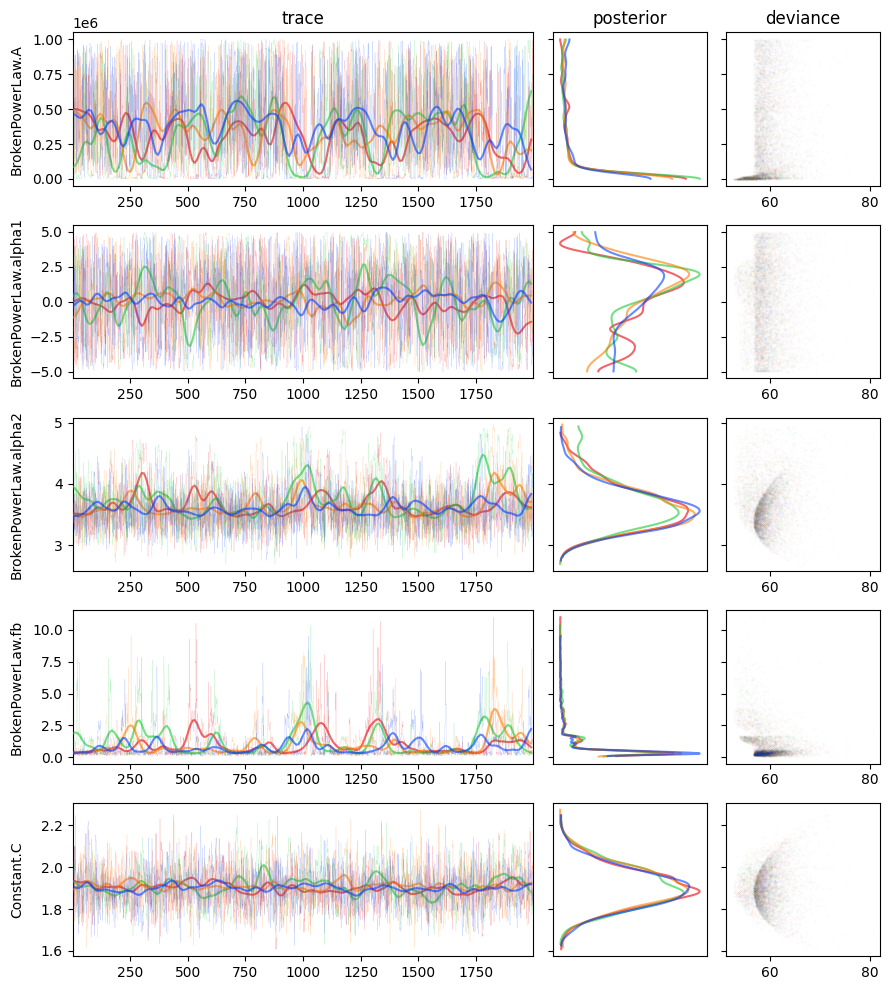

In [5]:
import arviz as az
from elisa.plot.misc import plot_trace

idata = fit.run_nuts()
idata.log_likelihood['total'] = idata.log_likelihood['I_obs'].sum(
    'I_obs_dim_0'
)
# az.plot_trace(idata, var_names=['~S', '~loglike'])
_ = plot_trace(
    idata,
    params=[
        'BrokenPowerLaw.A',
        'BrokenPowerLaw.alpha1',
        'BrokenPowerLaw.alpha2',
        'BrokenPowerLaw.fb',
        'Constant.C',
    ],
    axes_scale=['linear', 'linear', 'linear', 'linear', 'linear'],
)

In [9]:
import scipy.stats
from astropy.modeling import models
from stingray import Lightcurve, Powerspectrum
from stingray.modeling import PSDParEst, PSDPosterior, set_logprior

lc = Lightcurve(
    0.5 * (bins[:-1] + bins[1:]), rate, input_counts=False, frac_exp=expo
)
ps = Powerspectrum(lc, norm='leahy')


# define power law component
pl = models.PowerLaw1D()
bpl = models.BrokenPowerLaw1D()

# fix x_0 of power law component
pl.x_0.fixed = True

# define constant
c = models.Const1D()

# make compound model
plc = pl + c
bplc = bpl + c
lpost = PSDPosterior(ps.freq, ps.power, plc, m=ps.m)

# flat prior for the power law index
p_alpha = lambda alpha: ((-1.0 <= alpha) & (alpha <= 5.0))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((0.01 <= amplitude) & (amplitude <= 10.0))

# normal prior for the white noise parameter
p_whitenoise = lambda white_noise: scipy.stats.norm(2.0, 0.1).pdf(white_noise)

priors = {}
priors['alpha_0'] = p_alpha
priors['amplitude_0'] = p_amplitude
priors['amplitude_1'] = p_whitenoise


lpost.logprior = set_logprior(lpost, priors)
lpost = PSDPosterior(ps.freq, ps.power, plc, priors=priors, m=ps.m)
test_pars = [1.0, 2.0, 4.0]
print('log-prior: ' + str(lpost.logprior(test_pars)))
print('log-likelihood: ' + str(lpost.loglikelihood(test_pars)))
print('log-posterior: ' + str(lpost(test_pars)))

log-prior: -198.61635344021062
log-likelihood: -2403.054843117279
log-posterior: -2601.6711965574896


In [10]:
bplc

<CompoundModel(amplitude_0=1., x_break_0=1., alpha_1_0=1., alpha_2_0=1., amplitude_1=4.)>

In [14]:
pl = models.PowerLaw1D()
pl.x_0.fixed = True
bpl = models.BrokenPowerLaw1D()
c = models.Const1D()
m = pl + c
parest = PSDParEst(ps, fitmethod='L-BFGS-B', max_post=False)
starting_pars = [1.0, 1.0, 2.0]
lpost = PSDPosterior(ps.freq, ps.power, m, m=ps.m)
res = parest.fit(lpost, starting_pars)

print('best-fit parameters:')
for p, e in zip(res.p_opt, res.err, strict=False):
    print(f'{p:.4f} +/- {e:.4f}')
m

best-fit parameters:
25909.7542 +/- 1.0000
2.9071 +/- 0.2423
1.9754 +/- 0.1098


<CompoundModel(amplitude_0=25909.7541551, x_0_0=1., alpha_0=2.90713278, amplitude_1=1.975441)>

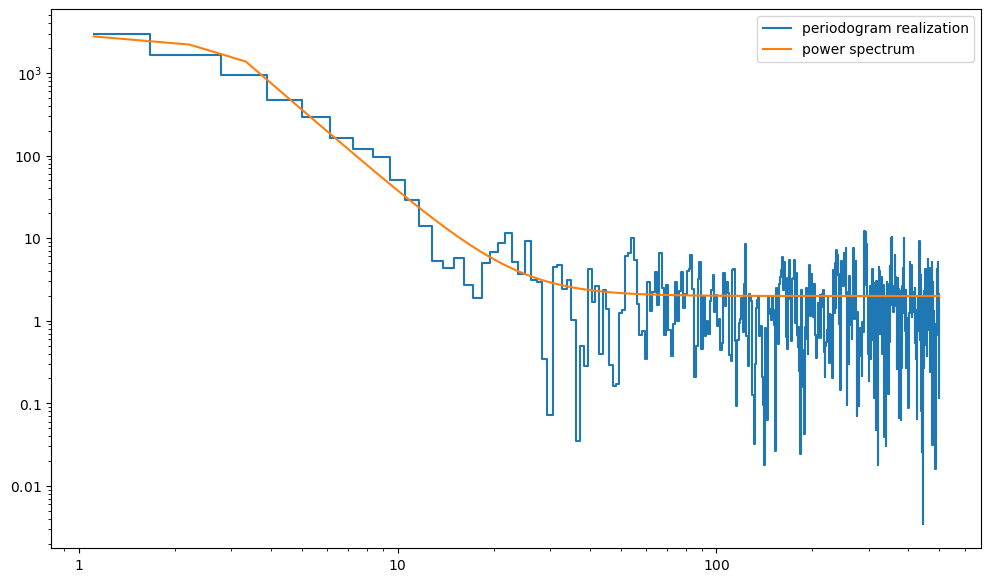

In [15]:
psd_shape = bplc(ps.freq)
plt.figure(figsize=(12, 7))
plt.loglog(ps.freq, ps.power, ds='steps-mid', label='psd realization')
plt.loglog(ps.freq, psd_shape, label='power spectrum')


plt.legend()

In [11]:
from numpyro.distributions.transforms import biject_to

t1 = {k: biject_to(v.support) for k, v in fit.model.prior.items()}

In [12]:
import jax
import jax.numpy as jnp
import optimistix as optx
from numpyro.infer.util import constrain_fn

params_names = list(t1.keys())


def get_loglike(unconstr_arr):
    sites = constrain_fn(
        model=fit.numpyro_model,
        model_args=(),
        model_kwargs={},
        params=dict(zip(params_names, unconstr_arr, strict=False)),
        return_deterministic=True,
    )
    return sites['loglike']


# def residual(unconstr_arr):
#     loglike = get_loglike(unconstr_arr)
#     return jnp.sqrt(-2 * loglike)

In [13]:
def residual(x):
    unconstr_params = dict(zip(params_names, x, strict=False))
    constr_params = {k: v(unconstr_params[k]) for k, v in t1.items()}
    s = fit.model.power(constr_params, fit.psd.freq_bins)
    i = fit.psd.power
    loglike = -jnp.log(s) - i / s - (-jnp.log(i) - 1)
    return jnp.sqrt(-2 * loglike)


lm_solver = optx.LevenbergMarquardt(rtol=0.0, atol=1e-6)
_residual = jax.jit(lambda x, aux: residual(x))


def lm(init):
    res = optx.least_squares(
        fn=_residual,
        solver=lm_solver,
        y0=init,
        max_steps=1024,
        throw=True,
    )
    grad_norm = jnp.linalg.norm(res.state.f_info.compute_grad())
    return res.value, grad_norm


_lm = jax.jit(lm)
init = {
    'BrokenPowerLaw.alpha1': 0.33034704,
    'BrokenPowerLaw.fb': 2.98367364,
    'BrokenPowerLaw.alpha2': 3.32582127,
    'BrokenPowerLaw.A': 1.0,
    'Constant.C': 2.0,
}
unconstr_init = {k: t1[k].inv(v) for k, v in init.items()}
unconstr_init = jnp.array([unconstr_init[k] for k in params_names])
unconstr_arr, g = _lm(unconstr_init)

In [14]:
unconstr_params = dict(zip(params_names, unconstr_arr, strict=False))
constr_params = {k: v(unconstr_params[k]) for k, v in t1.items()}
constr_params

{'BrokenPowerLaw.alpha1': Array(2.82817362, dtype=float64),
 'BrokenPowerLaw.fb': Array(25.58398134, dtype=float64),
 'BrokenPowerLaw.alpha2': Array(7.58393153, dtype=float64),
 'BrokenPowerLaw.A': Array(2.27411209, dtype=float64),
 'Constant.C': Array(1.90785821, dtype=float64)}

In [15]:
bplc

<CompoundModel(amplitude_0=1993.29912491, x_break_0=2.9831618, alpha_1_0=0.33260463, alpha_2_0=3.32424081, amplitude_1=1.9923031)>

In [16]:
sum(residual(unconstr_arr) ** 2) / len(fit.psd.power)

Array(1.1490877, dtype=float64)

Array(0.22402432, dtype=float64)

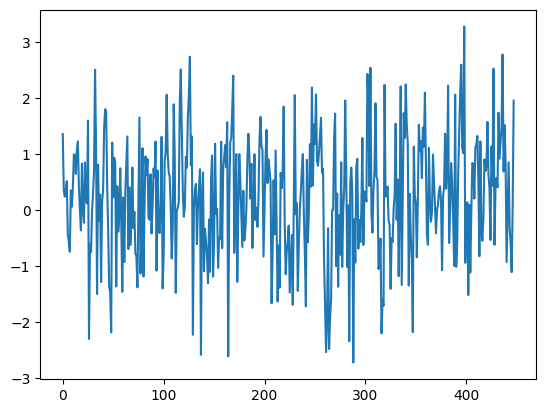

In [17]:
sign = np.where(
    fit.model.power(constr_params, fit.psd.freq_bins) > ps.power[1:], 1.0, -1.0
)
plt.plot(sign * residual(unconstr_arr))
np.mean(sign * residual(unconstr_arr))

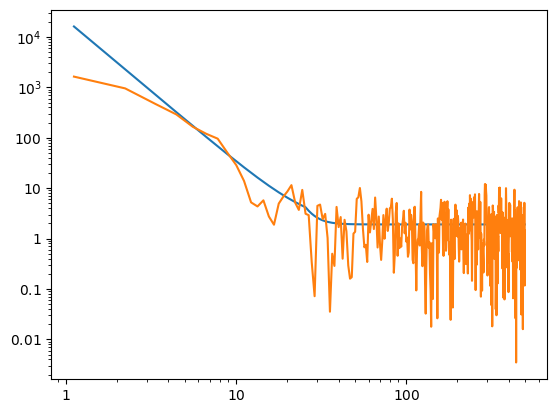

In [18]:
plt.loglog(fit.psd.freq, fit.model.power(constr_params, fit.psd.freq_bins))
plt.loglog(fit.psd.freq, ps.power[1:])